## Import Library

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report


from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import MaxPooling2D, Dense, Dropout,Flatten, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import ResNet50, Xception
from keras import layers
#from keras.optimizers import Adam, RMSprop

warnings.filterwarnings(action="ignore")
%matplotlib inline

In [ ]:
base_dir = 'drive/MyDrive/Project/Tekbio/Dataset/Brain_Tumor'
labels = sorted(os.listdir('drive/MyDrive/Project/Tekbio/Dataset/Brain_Tumor/train'))
target_size = target_size=(150,150)
NUM_CLASSES = len(labels)
batch_size = 32

In [ ]:
labels

['Abnormal', 'Normal']

In [ ]:
os.listdir(base_dir)

['train', 'test']

In [ ]:
list_train = [len(os.listdir('drive/MyDrive/Project/Tekbio/Dataset/Brain_Tumor/train/Abnormal')), len(os.listdir('drive/MyDrive/Project/Tekbio/Dataset/Brain_Tumor/train/Normal'))]
list_test = [len(os.listdir('drive/MyDrive/Project/Tekbio/Dataset/Brain_Tumor/test/Abnormal')), len(os.listdir('drive/MyDrive/Project/Tekbio/Dataset/Brain_Tumor/test/Normal'))]

jml_train = min(list_train)
jml_test = min(list_test)

print(jml_train)
print(jml_test)

1346
337


## Pengolahan Data

### Grouping Data

In [ ]:
def grouping_data(dir_image, total_image):
    data_img = {}
    data_dir = {}
    for label in labels:
        data_dir[label] = os.path.join(dir_image, label)
        data_img[label] = os.listdir(data_dir[label])

    img_data = []
    label_data = []

    for label in labels:
        for i in range(total_image):
            img_data.append(os.path.join(data_dir[label], data_img[label][i]))
            label_data.append(label)
            
    # convert data ke dataframe
    Fseries = pd.Series(img_data, name="image")
    Lseries = pd.Series(label_data, name="labels")
    object_data = pd.concat([Fseries,Lseries], axis=1)
    
    return pd.DataFrame(object_data)

In [ ]:
# mengambil data train
train_dir = os.path.join(base_dir,"train")
data_train_df = grouping_data(train_dir, jml_train)

# mengambil data test
test_dir = os.path.join(base_dir,"test")
data_test_df = grouping_data(test_dir, jml_test)

In [ ]:
print(data_train_df["image"][0])
print(data_test_df["image"][0])

drive/MyDrive/Project/Tekbio/Dataset/Brain_Tumor/train/Abnormal/Image508.jpg
drive/MyDrive/Project/Tekbio/Dataset/Brain_Tumor/test/Abnormal/Image3690.jpg


In [ ]:
data_train_df

,image,labels
0,drive/MyDrive/Project/Tekbio/Dataset/Brain_Tum...,Abnormal
1,drive/MyDrive/Project/Tekbio/Dataset/Brain_Tum...,Abnormal
2,drive/MyDrive/Project/Tekbio/Dataset/Brain_Tum...,Abnormal
3,drive/MyDrive/Project/Tekbio/Dataset/Brain_Tum...,Abnormal
4,drive/MyDrive/Project/Tekbio/Dataset/Brain_Tum...,Abnormal
...,...,...
2687,drive/MyDrive/Project/Tekbio/Dataset/Brain_Tum...,Normal
2688,drive/MyDrive/Project/Tekbio/Dataset/Brain_Tum...,Normal
2689,drive/MyDrive/Project/Tekbio/Dataset/Brain_Tum...,Normal
2690,drive/MyDrive/Project/Tekbio/Dataset/Brain_Tum...,Normal


In [ ]:
data_test_df

,image,labels
0,drive/MyDrive/Project/Tekbio/Dataset/Brain_Tum...,Abnormal
1,drive/MyDrive/Project/Tekbio/Dataset/Brain_Tum...,Abnormal
2,drive/MyDrive/Project/Tekbio/Dataset/Brain_Tum...,Abnormal
3,drive/MyDrive/Project/Tekbio/Dataset/Brain_Tum...,Abnormal
4,drive/MyDrive/Project/Tekbio/Dataset/Brain_Tum...,Abnormal
...,...,...
669,drive/MyDrive/Project/Tekbio/Dataset/Brain_Tum...,Normal
670,drive/MyDrive/Project/Tekbio/Dataset/Brain_Tum...,Normal
671,drive/MyDrive/Project/Tekbio/Dataset/Brain_Tum...,Normal
672,drive/MyDrive/Project/Tekbio/Dataset/Brain_Tum...,Normal


### Split dan Load Data
Split to Train_Set and Val_Set , Load Data With keras API

In [ ]:
#Membagi sampel data
train_set, val_set = train_test_split(data_train_df, test_size=0.2, random_state=42)


In [ ]:
#shape of splitted data
print(train_set.shape)
print(val_set.shape)

(2153, 2)
(539, 2)


In [ ]:
#Generate batches of tensor image data with real-time data augmentation.
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="image",y_col="labels",
                                      target_size=target_size,
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=batch_size,
                                      shuffle=True 
                                     )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="image", y_col="labels",
                                    target_size=target_size,
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=batch_size,
                                    shuffle=False
                                   )
test = image_gen.flow_from_dataframe(dataframe= data_test_df,x_col="image", y_col="labels",
                                     target_size=target_size,
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=batch_size,
                                     shuffle= False
                                    )

Found 2153 validated image filenames belonging to 2 classes.
Found 539 validated image filenames belonging to 2 classes.
Found 674 validated image filenames belonging to 2 classes.


In [ ]:
print(type(train))
print(type(test))
print(type(val))

<class 'keras.preprocessing.image.DataFrameIterator'>
<class 'keras.preprocessing.image.DataFrameIterator'>
<class 'keras.preprocessing.image.DataFrameIterator'>


In [ ]:
classes=list(train.class_indices.keys())
print (classes)

['Abnormal', 'Normal']


### Preview Data

In [ ]:
def show_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator 
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

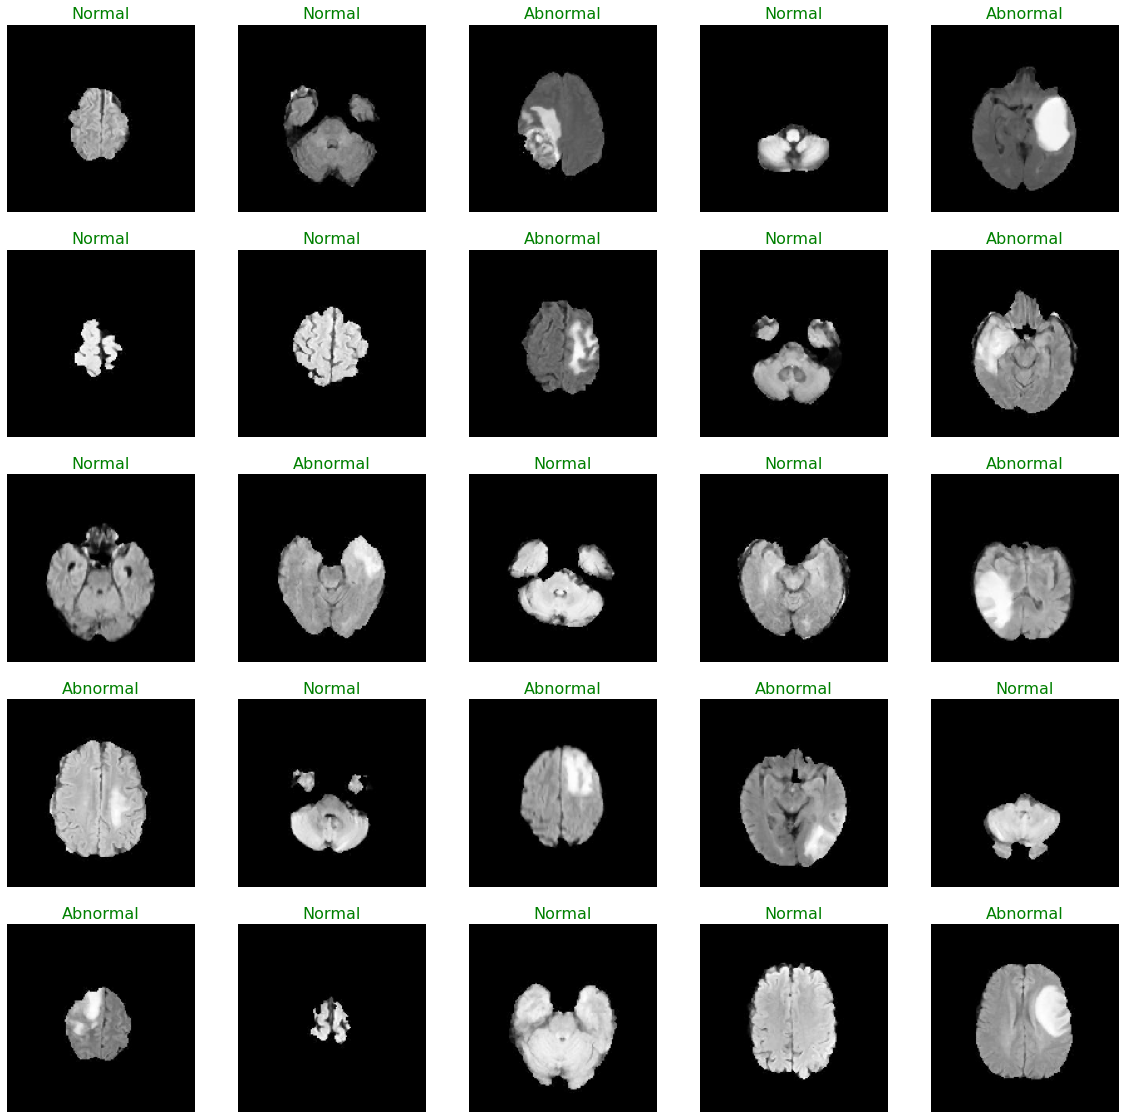

In [ ]:
show_images(train)

## Pengaturan Model

In [ ]:
steps_per_epoch = train_set.shape[0] // batch_size
validation_step = val_set.shape[0] // batch_size
epoch = 50

In [ ]:
checkpoint1 = ModelCheckpoint('drive/MyDrive/Project/Tekbio/Model_vgg16_30.h5', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='auto',
                              )

checkpoint2 = ModelCheckpoint('drive/MyDrive/Project/Tekbio/Model_resnet50_30.h5', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='auto',
                              )

checkpoint3 = ModelCheckpoint('drive/MyDrive/Project/Tekbio/Model_Xception_100.h5', 
                              verbose=1, 
                              save_best_only=True, 
                              mode='auto',
                              )

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.70, 
                              patience = 5, 
                              min_delta = 0.0001,
                              mode='auto',
                              verbose=1)

### VGG16

#### Deklarasi Model

In [ ]:
# configuration base model
base_model = VGG16(
    include_top=False, 
    input_shape=target_size + (3,)
)
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
# custom model
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

model.layers[0].trainable = False

model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 2)                 16386     
                                                                 
Total params: 14,731,074
Trainable params: 16,386
Non-trainable params: 14,714,688
_________________________________________________________________


#### Train Model

In [ ]:
#fitting model

start = time.time()
History1 = model.fit(train, 
                     validation_data= val, 
                     validation_steps=validation_step, 
                     steps_per_epoch=steps_per_epoch, 
                     epochs=epoch, 
                     verbose=1, 
                     callbacks=[checkpoint1, reduce_lr])
print("Total time: ", time.time() - start, "seconds")

Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 0.4510 - accuracy: 0.8034
Epoch 1: val_loss improved from inf to 0.29451, saving model to drive/MyDrive/Project/Tekbio/Model_vgg16_30.h5
67/67 [==============================] - 22s 232ms/step - loss: 0.4510 - accuracy: 0.8034 - val_loss: 0.2945 - val_accuracy: 0.8789 - lr: 0.0010
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 0.3003 - accuracy: 0.8685
Epoch 2: val_loss improved from 0.29451 to 0.23359, saving model to drive/MyDrive/Project/Tekbio/Model_vgg16_30.h5
67/67 [==============================] - 14s 210ms/step - loss: 0.3003 - accuracy: 0.8685 - val_loss: 0.2336 - val_accuracy: 0.9023 - lr: 0.0010
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 0.2585 - accuracy: 0.8944
Epoch 3: val_loss improved from 0.23359 to 0.21963, saving model to drive/MyDrive/Project/Tekbio/Model_vgg16_30.h5
67/67 [==============================] - 14s 210ms/step - loss: 0.2585 - accuracy: 0.89

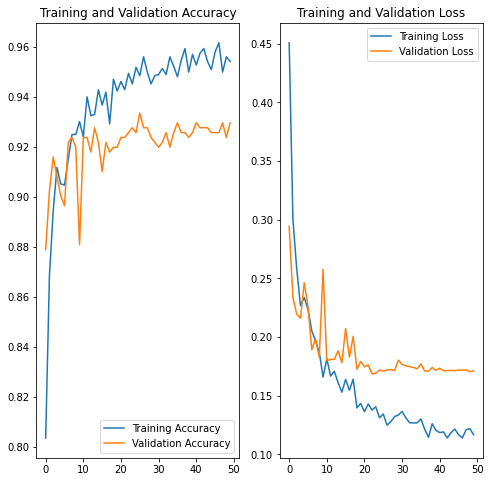

In [ ]:
# tampilkan hasil akurasi kedalam plot
accuracy1 = History1.history['accuracy']
val_accuracy1 = History1.history['val_accuracy']

loss1 = History1.history['loss']
val_loss1 = History1.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy1, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss1, label='Training Loss')
plt.plot(epochs_range, val_loss1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### ResNet 50

#### Deklarasi Model

In [ ]:
# configuration base model
base_model1 = ResNet50(
    include_top=False, 
    input_shape=target_size + (3,)
)
base_model1.summary()


94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

In [ ]:
# custom model
model1 = Sequential()
model1.add(base_model1)
model1.add(layers.Flatten())
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(NUM_CLASSES, activation='softmax'))

model1.layers[0].trainable = False

model1.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_1 (Dropout)         (None, 51200)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 102402    
                                                                 
Total params: 23,690,114
Trainable params: 102,402
Non-trainable params: 23,587,712
_________________________________________________________________


#### Train Model

In [ ]:
start = time.time()
History2 = model1.fit(train, 
                     validation_data= val, 
                     validation_steps=validation_step, 
                     steps_per_epoch=steps_per_epoch, 
                     epochs=epoch, 
                     verbose=1, 
                     callbacks=[checkpoint2, reduce_lr])
print("Total time: ", time.time() - start, "seconds")

Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 0.5279 - accuracy: 0.8029
Epoch 1: val_loss improved from inf to 0.57296, saving model to drive/MyDrive/Project/Tekbio/Model_resnet50_30.h5
67/67 [==============================] - 20s 225ms/step - loss: 0.5279 - accuracy: 0.8029 - val_loss: 0.5730 - val_accuracy: 0.8301 - lr: 0.0010
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 0.3750 - accuracy: 0.8557
Epoch 2: val_loss improved from 0.57296 to 0.28139, saving model to drive/MyDrive/Project/Tekbio/Model_resnet50_30.h5
67/67 [==============================] - 14s 202ms/step - loss: 0.3750 - accuracy: 0.8557 - val_loss: 0.2814 - val_accuracy: 0.8789 - lr: 0.0010
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 0.3627 - accuracy: 0.8553
Epoch 3: val_loss improved from 0.28139 to 0.25820, saving model to drive/MyDrive/Project/Tekbio/Model_resnet50_30.h5
67/67 [==============================] - 14s 204ms/step - loss: 0.3627 - accur

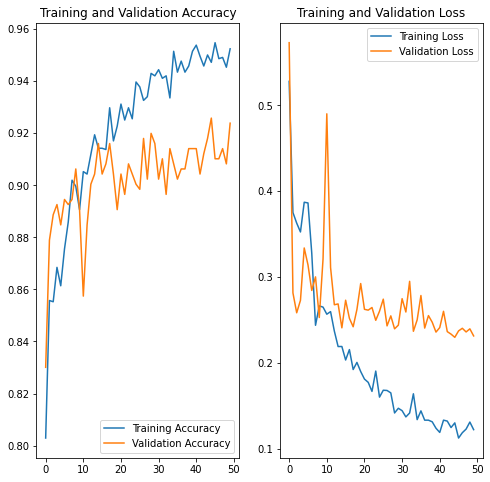

In [ ]:
# tampilkan hasil akurasi kedalam plot
accuracy2 = History2.history['accuracy']
val_accuracy2 = History2.history['val_accuracy']

loss2 = History2.history['loss']
val_loss2 = History2.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy2, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss2, label='Training Loss')
plt.plot(epochs_range, val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Xception

#### Deklarasi Model

In [ ]:
Xcept = Xception(
    include_top=False, 
    input_shape=target_size + (3,)
)
Xcept.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_3[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                          

In [ ]:
model2 = Sequential()
model2.add(Xcept)
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(NUM_CLASSES, activation='softmax'))

model2.layers[0].trainable = False

model2.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy']
)

model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_2 (Dropout)         (None, 51200)             0         
                                                                 
 dense_2 (Dense)             (None, 2)                 102402    
                                                                 
Total params: 20,963,882
Trainable params: 102,402
Non-trainable params: 20,861,480
_________________________________________________________________


#### Train Model

In [ ]:
start = time.time()
History3 = model2.fit(train, 
                     validation_data= val, 
                     validation_steps=validation_step, 
                     steps_per_epoch=steps_per_epoch, 
                     epochs=epoch, 
                     verbose=1, 
                     callbacks=[checkpoint3, reduce_lr])
print("Total time: ", time.time() - start, "seconds")

Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 0.6628 - accuracy: 0.8421
Epoch 1: val_loss improved from inf to 0.28244, saving model to drive/MyDrive/Project/Tekbio/Model_Xception_100.h5
67/67 [==============================] - 19s 226ms/step - loss: 0.6628 - accuracy: 0.8421 - val_loss: 0.2824 - val_accuracy: 0.9043 - lr: 0.0010
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 0.3465 - accuracy: 0.9005
Epoch 2: val_loss did not improve from 0.28244
67/67 [==============================] - 12s 182ms/step - loss: 0.3465 - accuracy: 0.9005 - val_loss: 0.5257 - val_accuracy: 0.8672 - lr: 0.0010
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 0.2333 - accuracy: 0.9293
Epoch 3: val_loss did not improve from 0.28244
67/67 [==============================] - 12s 176ms/step - loss: 0.2333 - accuracy: 0.9293 - val_loss: 0.3702 - val_accuracy: 0.9160 - lr: 0.0010
Epoch 4/50
67/67 [==============================] - ETA: 0s - loss: 0.2092

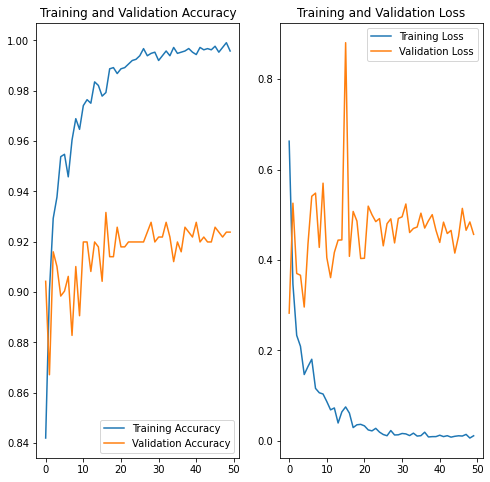

In [ ]:
# tampilkan hasil akurasi kedalam plot
accuracy3 = History3.history['accuracy']
val_accuracy3 = History3.history['val_accuracy']

loss3 = History3.history['loss']
val_loss3 = History3.history['val_loss']

epochs_range = range(epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy3, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss3, label='Training Loss')
plt.plot(epochs_range, val_loss3, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Evaluasi

#### Evaluasi untuk VGG16

In [ ]:
model1 = load_model('drive/MyDrive/Project/Tekbio/Model_vgg16_30.h5', )

In [ ]:
model1.evaluate(test, verbose=1)

22/22 [==============================] - 185s 9s/step - loss: 0.1763 - accuracy: 0.9362


[0.17627812922000885, 0.9362017512321472]

In [ ]:
pred1 = model1.predict(test)
pred1 = np.argmax(pred1, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
preds1 = [labels[k] for k in pred1]

In [ ]:
from sklearn.metrics import classification_report,accuracy_score

y_test = data_test_df.labels # set y_test to the expected output
print(classification_report(y_test, preds1))
print("Accuracy of the Model:",accuracy_score(y_test, preds1)*100,"%")

              precision    recall  f1-score   support

    Abnormal       0.95      0.92      0.93       337
      Normal       0.92      0.96      0.94       337

    accuracy                           0.94       674
   macro avg       0.94      0.94      0.94       674
weighted avg       0.94      0.94      0.94       674

Accuracy of the Model: 93.62017804154303 %


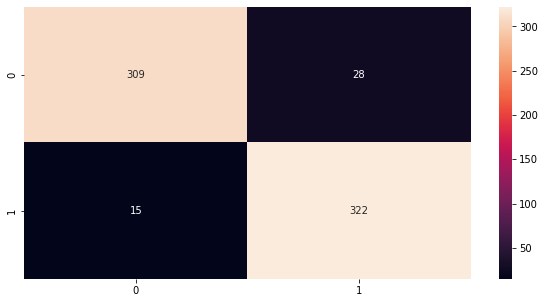

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm1 = confusion_matrix(y_test, preds1)
sns.heatmap(cm1, annot=True, fmt = 'g')

#### Evaluasi untuk ResNet50

In [ ]:
model2 = load_model('drive/MyDrive/Project/Tekbio/Model_resnet50_30.h5', )

In [ ]:
model2.evaluate(test, verbose=1)

22/22 [==============================] - 5s 154ms/step - loss: 0.2555 - accuracy: 0.9110


[0.2554903030395508, 0.9109792113304138]

In [ ]:
pred2 = model2.predict(test)
pred2 = np.argmax(pred2, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
preds2 = [labels[k] for k in pred2]

In [ ]:
from sklearn.metrics import classification_report,accuracy_score

y_test = data_test_df.labels # set y_test to the expected output
print(classification_report(y_test, preds2))
print("Accuracy of the Model:",accuracy_score(y_test, preds2)*100,"%")

              precision    recall  f1-score   support

    Abnormal       0.90      0.92      0.91       337
      Normal       0.92      0.90      0.91       337

    accuracy                           0.91       674
   macro avg       0.91      0.91      0.91       674
weighted avg       0.91      0.91      0.91       674

Accuracy of the Model: 91.0979228486647 %


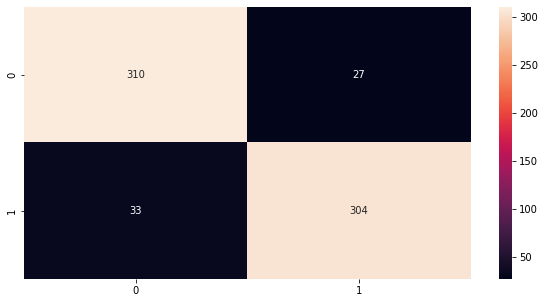

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm2 = confusion_matrix(y_test, preds2)
sns.heatmap(cm2, annot=True, fmt = 'g')

#### Evaluasi untuk Xception

In [ ]:
model3 = load_model('drive/MyDrive/Project/Tekbio/Model_Xception_100.h5', )

In [ ]:
model3.evaluate(test, verbose=1)

22/22 [==============================] - 5s 163ms/step - loss: 0.2960 - accuracy: 0.8843


[0.2960323691368103, 0.8842729926109314]

In [ ]:
pred3 = model3.predict(test)
pred3 = np.argmax(pred3, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
preds3 = [labels[k] for k in pred3]

In [ ]:
from sklearn.metrics import classification_report,accuracy_score

y_test = data_test_df.labels # set y_test to the expected output
print(classification_report(y_test, preds3))
print("Accuracy of the Model:",accuracy_score(y_test, preds3)*100,"%")

              precision    recall  f1-score   support

    Abnormal       0.89      0.88      0.88       337
      Normal       0.88      0.89      0.88       337

    accuracy                           0.88       674
   macro avg       0.88      0.88      0.88       674
weighted avg       0.88      0.88      0.88       674

Accuracy of the Model: 88.4272997032641 %


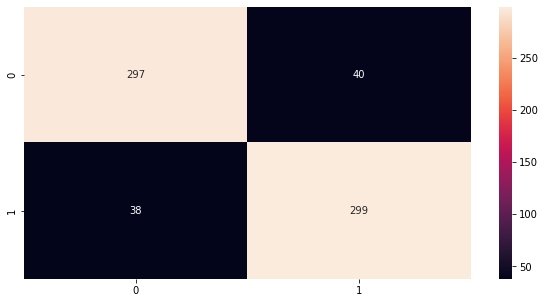

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize = (10,5))
cm2 = confusion_matrix(y_test, preds3)
sns.heatmap(cm2, annot=True, fmt = 'g')

## Perbandingan

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [ ]:
hasil1 = [(accuracy_score(y_test, preds1) * 100), (recall_score(y_test, preds1,  pos_label='Abnormal') * 100), (precision_score(y_test, preds1,  pos_label='Abnormal') * 100)]
hasil2 = [(accuracy_score(y_test, preds2) * 100), (recall_score(y_test, preds2,  pos_label='Abnormal') * 100), (precision_score(y_test, preds2,  pos_label='Abnormal') * 100)]
hasil3 = [(accuracy_score(y_test, preds3) * 100), (recall_score(y_test, preds3,  pos_label='Abnormal') * 100), (precision_score(y_test, preds3,  pos_label='Abnormal') * 100)]


dic = {'V66-16' : [str(round((hasil1[0]))) + '%', str(round((hasil1[1]))) + '%', str(round((hasil1[2]))) + '%'], 
       'ResNet50' : [str(round((hasil2[0]))) + '%', str(round((hasil2[1]))) + '%', str(round((hasil2[2]))) + '%'],
       'Xception' : [str(round((hasil3[0]))) + '%', str(round((hasil3[1]))) + '%', str(round((hasil3[2]))) + '%']}

df_hasil = pd.DataFrame(data = dic, index=['Accuracy', 'Recall', 'Precision'])
df_hasil

,V66-16,ResNet50,Xception
Accuracy,94%,91%,88%
Recall,92%,92%,88%
Precision,95%,90%,89%
